In [ ]:
!pip install statsmodels


In [1]:
import tensorflow as tf
import librosa
import vggish_slim, vggish_params, vggish_input, vggish_postprocess
import umap
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import pandas as pd
import datetime
import matplotlib.colors as mcolors
from sklearn.metrics import silhouette_samples, silhouette_score

2024-08-23 13:05:56.500099: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
audio_folder = '/Users/caihanzhe/Desktop/Comoros_Data_1'
audio_files = []
site_date_time_info = []

In [4]:
for subdir in os.listdir(audio_folder):
    subdir_path = os.path.join(audio_folder, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('.WAV'):
                audio_files.append(os.path.join(subdir_path, file))
                site = subdir.split(' - ')[0]
                date = datetime.datetime.strptime(file, '%Y%m%d_%H%M%S.WAV')
                time = file.split('_')[1]
                time = time[:2] + ":00:01"
                site_date_time_info.append((site, date, time))

In [4]:
checkpoint_path = '/Users/caihanzhe/Desktop/Python/Comoros/Vggish_1/vggish_model.ckpt'
pca_params_path = '/Users/caihanzhe/Desktop/Python/Comoros/Vggish_1/vggish_pca_params.npz'

In [6]:
embeddings = []
sites = []
dates = []
times = []

In [7]:
with tf.compat.v1.Graph().as_default(), tf.compat.v1.Session() as sess:
    vggish_slim.define_vggish_slim()
    vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

    features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)
    postprocessor = vggish_postprocess.Postprocessor(pca_params_path)

    for i, audio_path in enumerate(audio_files):
        waveform, sr = librosa.load(audio_path, sr=vggish_params.SAMPLE_RATE)
        examples = vggish_input.waveform_to_examples(waveform, sr)
        embedding_batch = sess.run(embedding_tensor, feed_dict={features_tensor: examples})
        postprocessed_batch = postprocessor.postprocess(embedding_batch)
        embeddings.append(postprocessed_batch)

        sites.extend([site_date_time_info[i][0]] * postprocessed_batch.shape[0])
        dates.extend([site_date_time_info[i][1]] * postprocessed_batch.shape[0])
        times.extend([site_date_time_info[i][2]] * postprocessed_batch.shape[0])

/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from /Users/caihanzhe/Desktop/Python/Comoros/Vggish_1/vggish_model.ckpt


2024-08-14 22:29:19.400382: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [8]:
embeddings_np = np.vstack(embeddings)
df = pd.DataFrame(embeddings_np)
df['site'] = sites
df['date'] = dates
df['time'] = times

In [2]:
df = pd.read_csv('/Users/caihanzhe/Desktop/Python/Comoros/Vggish_1/df.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,site,date,time,wav_index
0,96,73,148,46,130,131,4,154,253,125,...,203,214,119,145,114,231,S18,2023-07-16 15:00:01,15:00:01,1
1,97,62,148,28,131,118,18,146,223,130,...,243,246,113,43,210,121,S18,2023-07-16 15:00:01,15:00:01,2
2,97,74,145,12,142,115,22,156,240,150,...,255,242,92,53,102,252,S18,2023-07-16 15:00:01,15:00:01,3
3,97,70,155,12,134,122,27,152,223,134,...,255,238,54,62,116,160,S18,2023-07-16 15:00:01,15:00:01,4
4,91,67,141,28,129,127,20,148,234,140,...,249,224,92,65,162,85,S18,2023-07-16 15:00:01,15:00:01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356124,72,92,133,15,108,122,20,163,255,145,...,255,175,135,229,201,255,S19,2023-07-18 05:45:01,05:00:01,307
356125,73,81,149,21,121,119,17,159,255,139,...,249,149,20,196,180,255,S19,2023-07-18 05:45:01,05:00:01,308
356126,73,87,134,19,110,121,30,166,255,147,...,255,206,169,185,166,255,S19,2023-07-18 05:45:01,05:00:01,309
356127,72,87,134,14,100,126,2,170,255,135,...,255,165,166,179,225,255,S19,2023-07-18 05:45:01,05:00:01,310


In [22]:
df.to_csv('/Users/caihanzhe/Desktop/Python/Comoros/Vggish_1/df.csv', index=False)

In [10]:
df['wav_index'] = df.groupby(['site', 'date']).cumcount() + 1

In [5]:
result = []

In [6]:
for (site, date), group in df.groupby(['site', 'date']):
    num_embeddings = len(group)
    base_size = num_embeddings // 5
    remainder = num_embeddings % 5
    part_sizes = [base_size] * 5
    for i in range(remainder):
        part_sizes[i] += 1
    
    indices = np.cumsum([0] + part_sizes)
    for i in range(len(part_sizes)):
        part = group[(group['wav_index'] > indices[i]) & (group['wav_index'] <= indices[i+1])]
        averaged_embeddings = part.iloc[:, :-4].mean(axis=0)
        averaged_embeddings['site'] = site
        averaged_embeddings['time'] = date.strftime('%H:%M:%S')
        result.append(averaged_embeddings)

In [7]:
averaged_df = pd.DataFrame(result)

In [8]:
averaged_df

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,site,time
0,38.888889,137.031746,110.269841,0.000000,37.666667,120.412698,159.714286,151.015873,255.000000,169.174603,...,230.825397,253.095238,239.984127,169.206349,112.682540,177.158730,60.301587,248.587302,S1,18:00:01
1,36.467742,135.967742,113.370968,0.000000,47.016129,120.967742,155.483871,151.338710,255.000000,169.112903,...,238.193548,252.548387,240.016129,155.467742,111.741935,175.354839,48.500000,250.887097,S1,18:00:01
2,50.516129,120.145161,117.758065,0.822581,53.483871,112.741935,144.225806,138.419355,255.000000,167.903226,...,222.741935,252.129032,226.645161,163.774194,172.161290,158.548387,57.435484,239.564516,S1,18:00:01
3,42.387097,130.145161,113.193548,0.000000,43.661290,117.822581,155.596774,146.709677,255.000000,171.951613,...,238.387097,253.161290,240.419355,167.596774,140.370968,181.145161,61.903226,244.177419,S1,18:00:01
4,36.258065,139.677419,107.241935,0.000000,31.516129,123.903226,157.887097,155.500000,255.000000,166.435484,...,231.096774,247.370968,241.322581,136.758065,115.838710,191.580645,46.822581,243.983871,S1,18:00:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,44.190476,108.238095,135.301587,2.920635,86.841270,158.444444,72.952381,153.714286,252.904762,143.158730,...,147.523810,66.587302,218.666667,157.380952,174.698413,167.507937,105.253968,242.015873,S9,05:45:01
5731,60.967742,86.612903,144.032258,6.903226,114.096774,137.370968,57.822581,147.161290,247.370968,148.290323,...,126.193548,90.129032,217.000000,156.741935,143.532258,140.806452,100.467742,239.306452,S9,05:45:01
5732,58.064516,89.306452,139.258065,3.209677,111.129032,136.129032,65.193548,146.306452,250.274194,150.112903,...,142.693548,98.951613,230.403226,141.370968,159.709677,151.145161,101.209677,237.435484,S9,05:45:01
5733,49.612903,103.725806,139.838710,2.161290,110.838710,144.983871,79.435484,148.887097,252.725806,138.419355,...,130.870968,95.935484,232.645161,165.435484,144.451613,142.096774,96.419355,242.725806,S9,05:45:01


In [55]:
averaged_df.to_csv('/Users/caihanzhe/Desktop/Python/Comoros/Vggish_1/df_1min_aver.csv', index=False)

In [9]:
averaged_df['time'] = averaged_df['time'].str.slice(0, 5)

In [10]:
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(averaged_df.iloc[:, :-2])

In [11]:
reducer = umap.UMAP(random_state=42)
embeddings_np_2d = reducer.fit_transform(scaled_embeddings)

/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
averaged_df['UMAP1'] = embeddings_np_2d[:, 0]
averaged_df['UMAP2'] = embeddings_np_2d[:, 1]

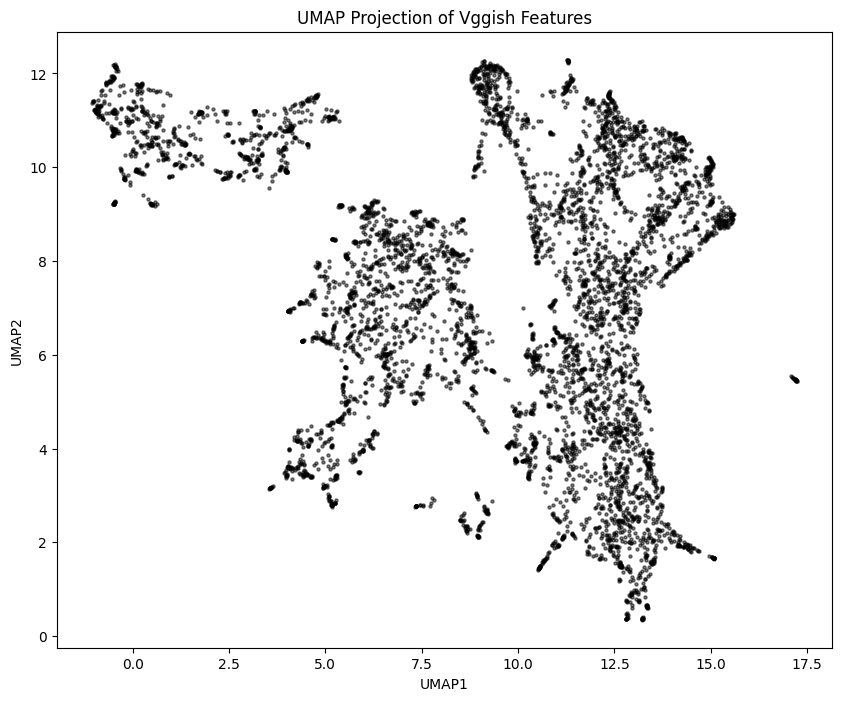

In [13]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(averaged_df['UMAP1'], averaged_df['UMAP2'], color='black', alpha=0.5, s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of Vggish Features')
plt.show()

In [14]:
time_color_mapping = {'00:00':'purple', '03:00':'brown', '05:45':'yellow', '08:00': 'red', '10:00': 'green', '15:00': 'blue', '18:00': 'orange', '21:00':'pink'}

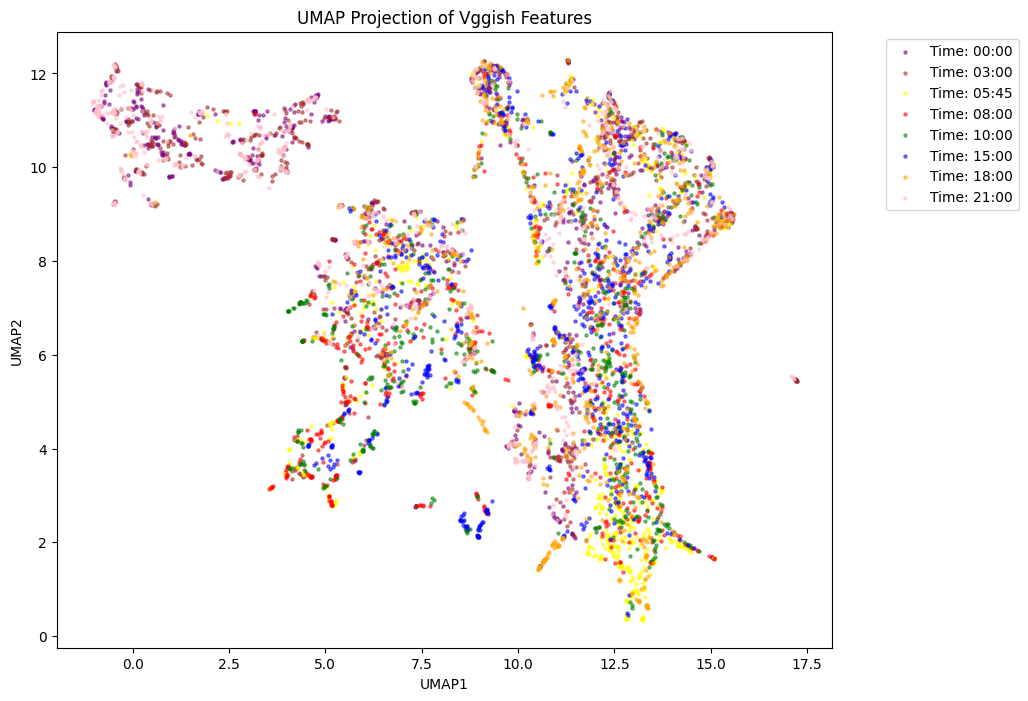

In [15]:
plt.figure(figsize=(10, 8))
for time_value, time_color in time_color_mapping.items():
    subset = averaged_df[averaged_df['time'] == time_value]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=time_color, label=f'Time: {time_value}', alpha=0.5, s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of Vggish Features')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In [16]:
def assign_day_night(row):
    if '08:00' <= row['time'] <= '18:00':
        return 'Day'
    else:
        return 'Night'

averaged_df['day_night'] = averaged_df.apply(assign_day_night, axis=1)

In [17]:
day_night_color_mapping = {'Day':'lightblue', 'Night': 'grey'}

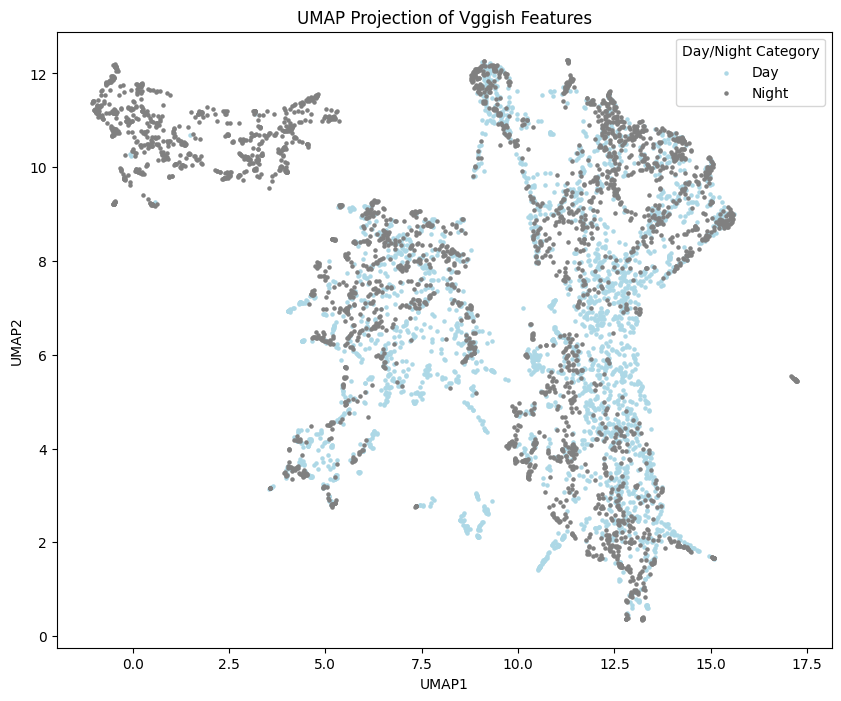

In [18]:
# Average Embeddings over 1 min Color by Day/Night
plt.figure(figsize=(10, 8))
for day_night_value, color_3 in day_night_color_mapping.items():
    subset_3 = averaged_df[averaged_df['day_night'] == day_night_value]
    plt.scatter(subset_3['UMAP1'], subset_3['UMAP2'], c=color_3, label=day_night_value, s=5)

plt.title('UMAP Projection of Vggish Features')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Day/Night Category')
plt.show()

In [19]:
def generate_distinct_colors(num_colors):
    hsv_colors = [(i / num_colors, 1.0, 1.0) for i in range(num_colors)]
    rgb_colors = [mcolors.hsv_to_rgb(hsv) for hsv in hsv_colors]
    return rgb_colors

num_colors = 40
distinct_colors = generate_distinct_colors(num_colors)

In [20]:
site_color_mapping = {site_: distinct_colors[i_ % len(distinct_colors)] for i_, site_ in enumerate(averaged_df['site'].unique())}

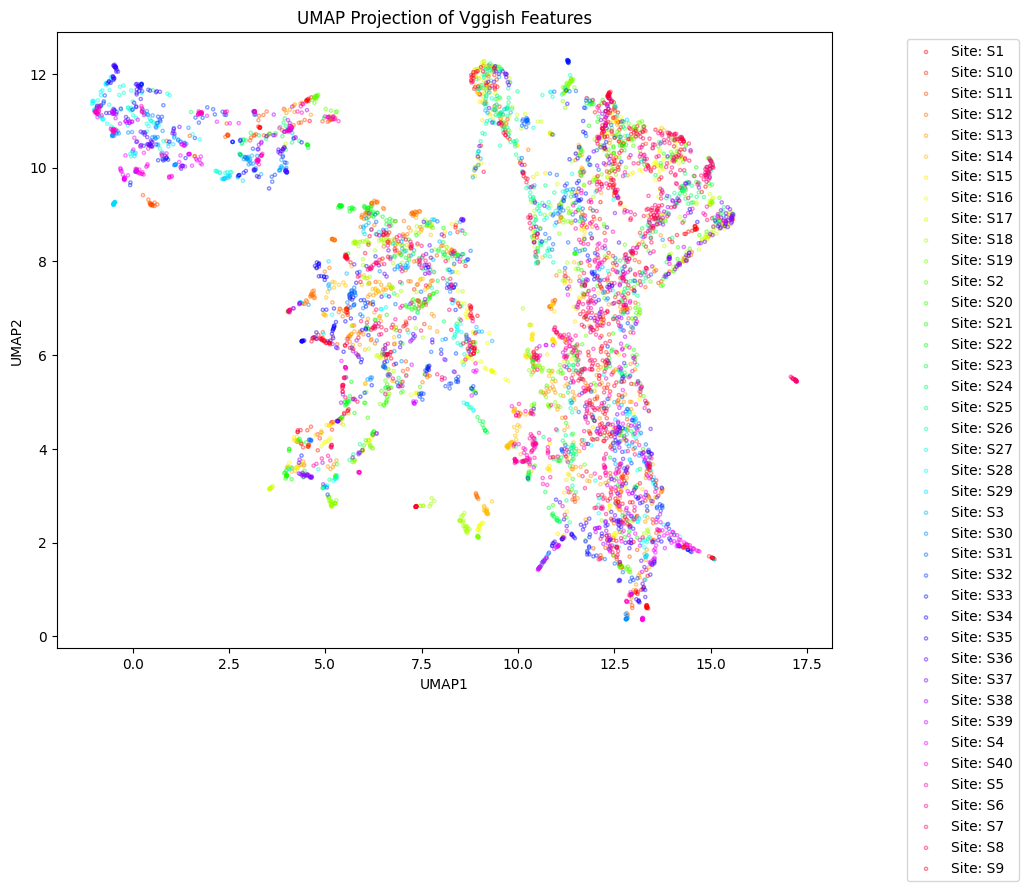

In [21]:
plt.figure(figsize=(10, 8))
for site_value, site_color in site_color_mapping.items():
    subset_ = averaged_df[averaged_df['site'] == site_value]
    plt.scatter(subset_['UMAP1'], subset_['UMAP2'], edgecolor=site_color, facecolor='none', label=f'Site: {site_value}', alpha=0.5, s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of Vggish Features')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In [22]:
#Forest cover of sites
forest_cover_df = pd.read_csv('/Users/caihanzhe/Desktop/mean_ndvi_values.csv')

In [23]:
averaged_df = pd.merge(averaged_df, forest_cover_df, left_on='site', right_on='plot_id', how='left')

In [24]:
averaged_df = averaged_df.drop(columns=['plot_id'])

In [25]:
forest_cover_color_mapping = {'High': 'green', 'Medium': 'orange', 'Low': 'red'}

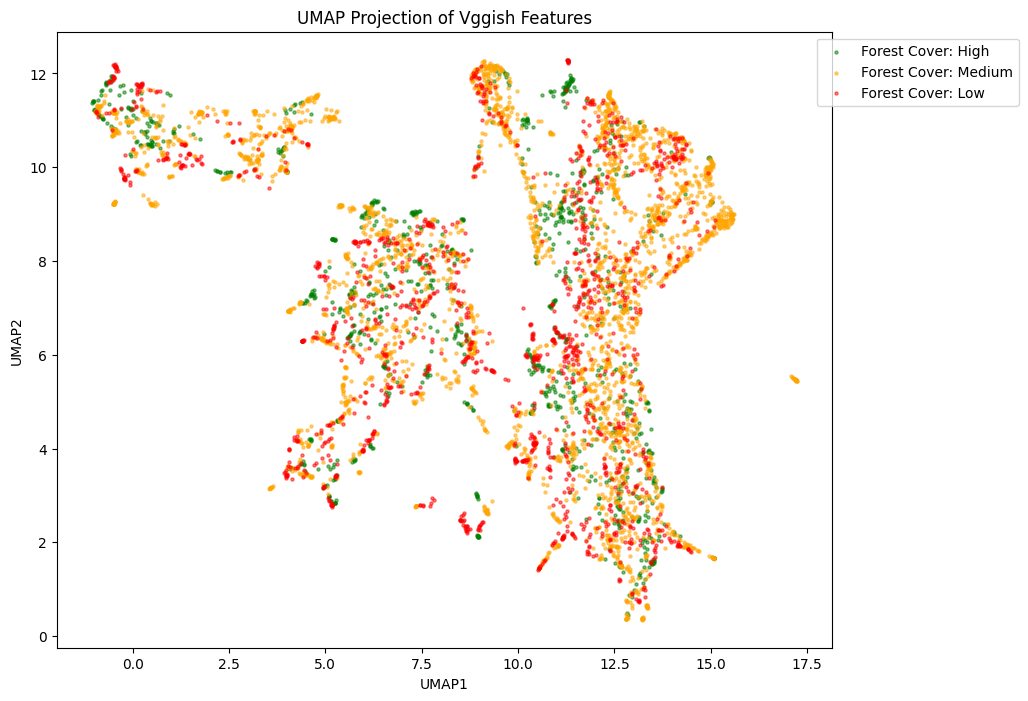

In [26]:
# Average embeddings over 1 min color by forest cover
plt.figure(figsize=(10, 8))
for cover_value, color in forest_cover_color_mapping.items():
    subset = averaged_df[averaged_df['Forest_Cover'] == cover_value]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=color, label=f'Forest Cover: {cover_value}', alpha=0.5, s=5)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of Vggish Features')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In [27]:
def assign_alt_level(row_):
    if 600 <= row_['alt'] < 900:
        return 'Low'
    elif 900 <= row_['alt'] < 1200:
        return 'Medium'
    else:
        return 'High'

averaged_df['alt_level'] = averaged_df.apply(assign_alt_level, axis=1)

In [28]:
alt_level_color_mapping = {'High': 'red', 'Medium': 'blue', 'Low': 'green'}

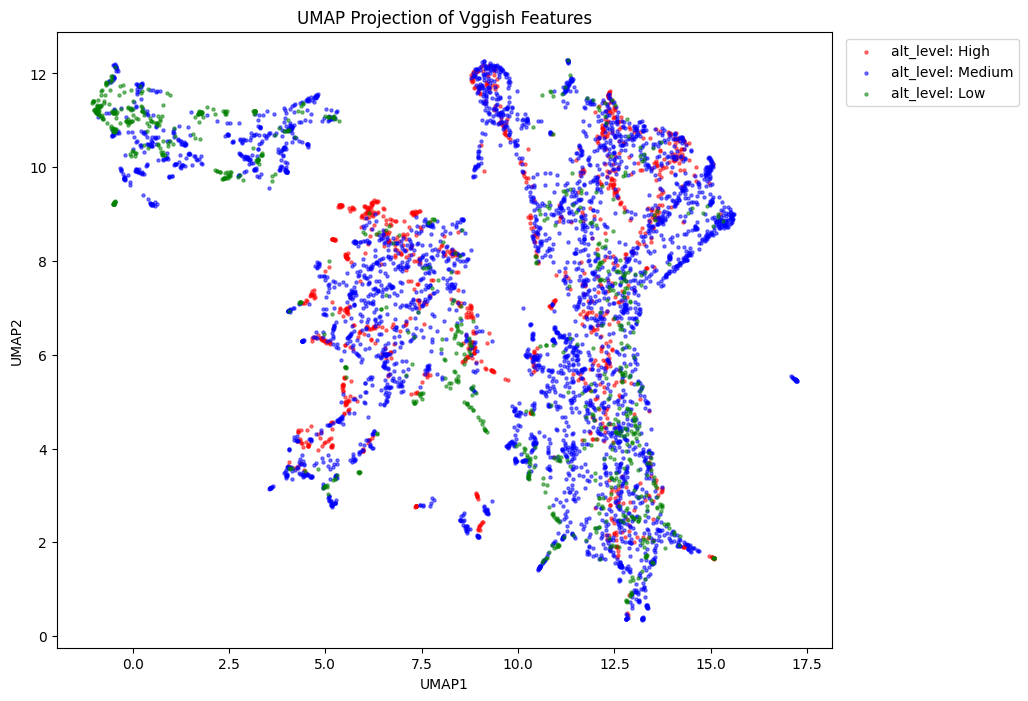

In [29]:
# Average embeddings over 1 min color by altitude level
plt.figure(figsize=(10, 8))
for alt_lvl_value, color in alt_level_color_mapping.items():
    subset = averaged_df[averaged_df['alt_level'] == alt_lvl_value]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=color, label=f'alt_level: {alt_lvl_value}', alpha=0.5, s=5)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of Vggish Features')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

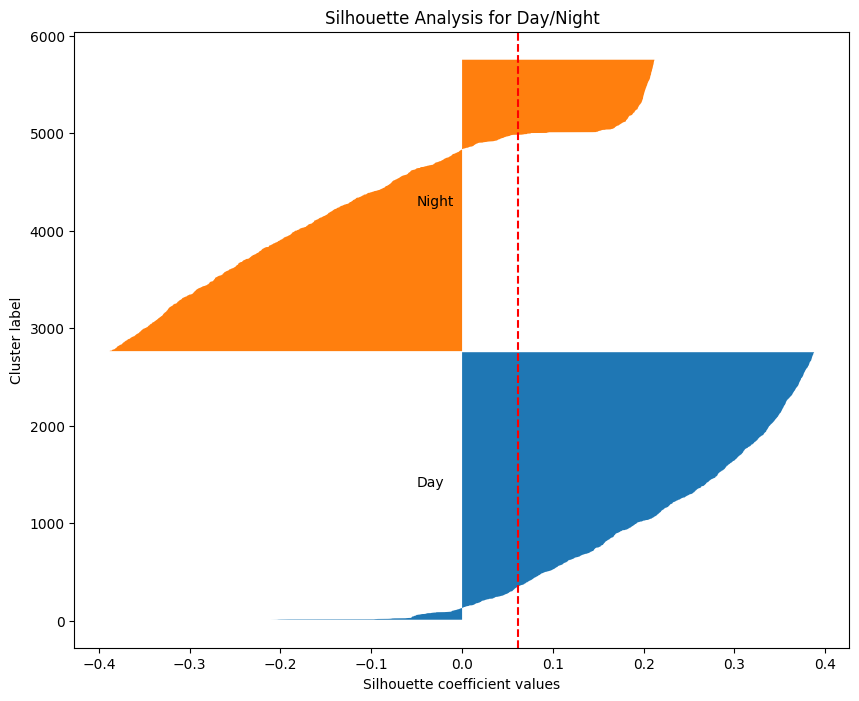

Silhouette Score for Day/Night: 0.06179436668753624


In [30]:
def silhouette_analysis(data, labels, title):
    silhouette_avg = silhouette_score(data, labels)
    sample_silhouette_values = silhouette_samples(data, labels)
    y_lower = 10

    plt.figure(figsize=(10, 8))
    for i in np.unique(labels):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.title(title)
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

    return silhouette_avg

silhouette_avg_day_night = silhouette_analysis(embeddings_np_2d, averaged_df['day_night'], 'Silhouette Analysis for Day/Night')
print(f'Silhouette Score for Day/Night: {silhouette_avg_day_night}')

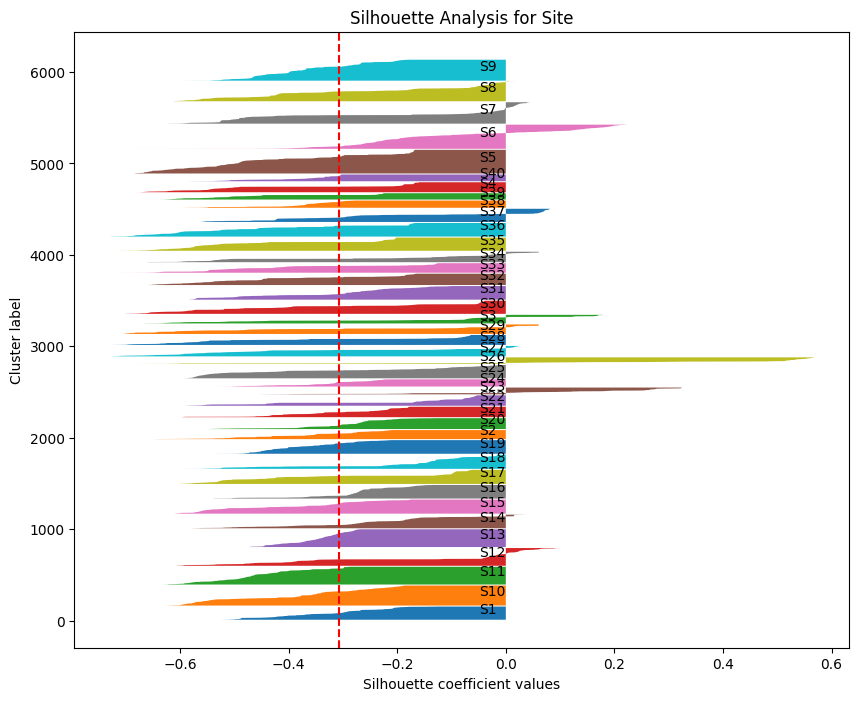

Silhouette Score for Site: -0.30676886439323425


In [31]:
silhouette_avg_site = silhouette_analysis(embeddings_np_2d, averaged_df['site'], 'Silhouette Analysis for Site')
print(f'Silhouette Score for Site: {silhouette_avg_site}')

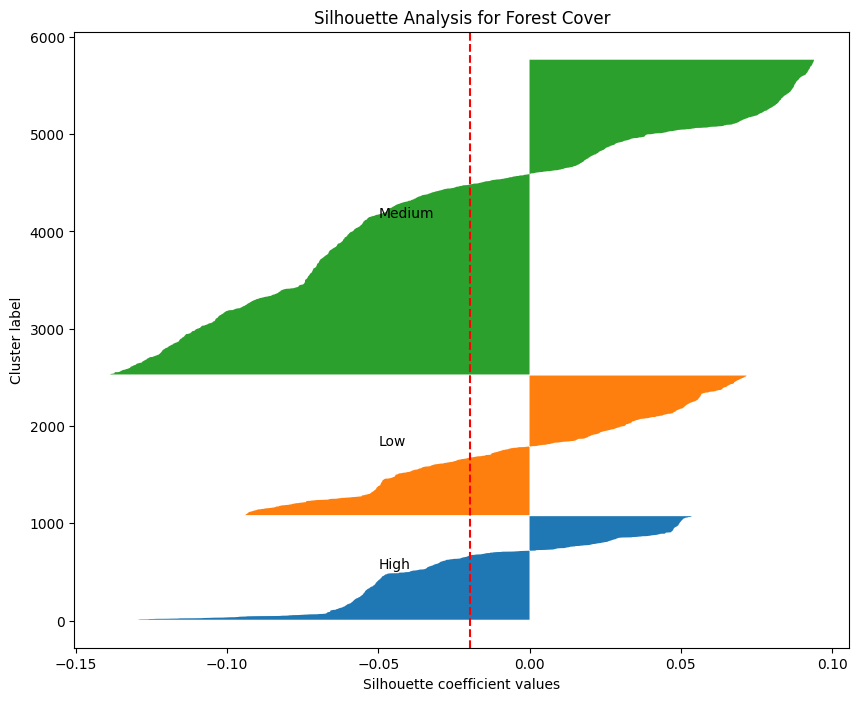

Silhouette Score for Forest Cover: -0.019803643226623535


In [32]:
silhouette_avg_forest_cover = silhouette_analysis(embeddings_np_2d, averaged_df['Forest_Cover'], 'Silhouette Analysis for Forest Cover')
print(f'Silhouette Score for Forest Cover: {silhouette_avg_forest_cover}')

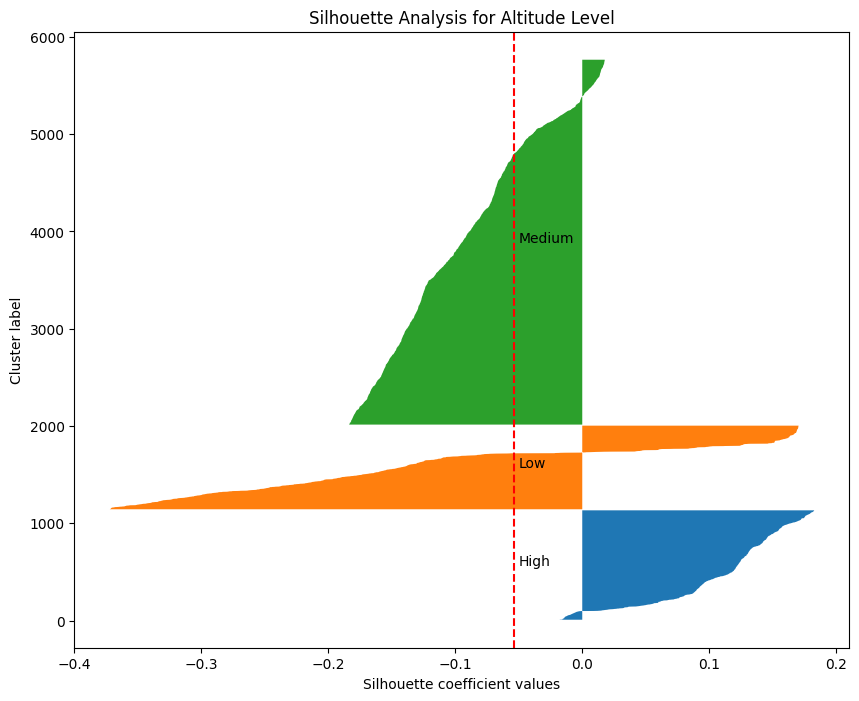

Silhouette Score for Altitude Level: -0.05365355312824249


In [33]:
silhouette_avg_alt_lvl = silhouette_analysis(embeddings_np_2d, averaged_df['alt_level'], 'Silhouette Analysis for Altitude Level')
print(f'Silhouette Score for Altitude Level: {silhouette_avg_alt_lvl}')

In [34]:
from sklearn.decomposition import PCA

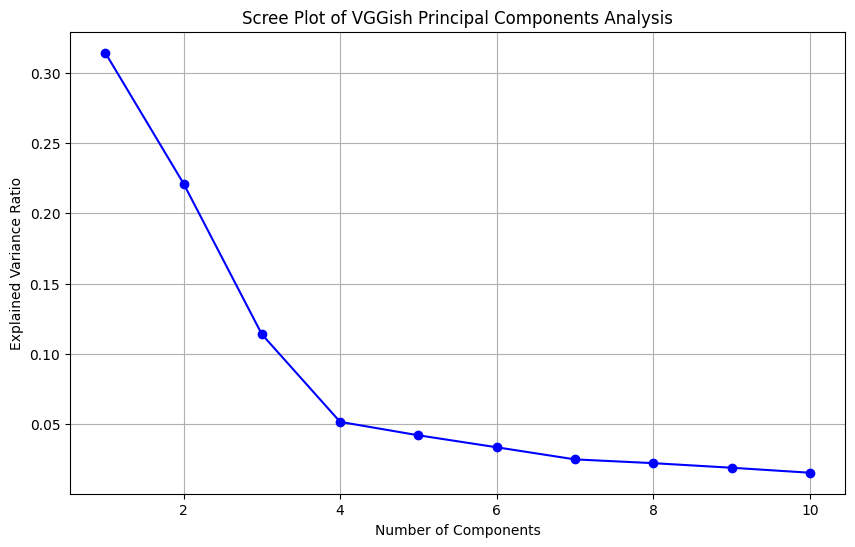

In [35]:
# PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(averaged_df.iloc[:, :128])
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.title('Scree Plot of VGGish Principal Components Analysis')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [36]:
# PCA
for i in range(4):
    averaged_df[f'PC{i+1}'] = principal_components[:, i]

In [37]:
# Mixed Effect models analysis
mixed_effect_model_df = averaged_df.dropna(subset=['NDVI'])

In [38]:
mixed_effect_model_df

,0,1,2,3,4,5,6,7,8,9,...,UMAP2,day_night,NDVI,Forest_Cover,alt,alt_level,PC1,PC2,PC3,PC4
0,38.888889,137.031746,110.269841,0.000000,37.666667,120.412698,159.714286,151.015873,255.000000,169.174603,...,0.637054,Day,0.277405,Medium,966,Medium,588.122841,-150.643614,-69.904351,-116.277808
1,36.467742,135.967742,113.370968,0.000000,47.016129,120.967742,155.483871,151.338710,255.000000,169.112903,...,0.659825,Day,0.277405,Medium,966,Medium,594.027421,-149.896630,-68.996522,-97.658956
2,50.516129,120.145161,117.758065,0.822581,53.483871,112.741935,144.225806,138.419355,255.000000,167.903226,...,0.662284,Day,0.277405,Medium,966,Medium,570.505040,-136.270620,-101.349183,-127.982788
3,42.387097,130.145161,113.193548,0.000000,43.661290,117.822581,155.596774,146.709677,255.000000,171.951613,...,0.666300,Day,0.277405,Medium,966,Medium,584.096910,-143.785425,-68.344157,-118.058371
4,36.258065,139.677419,107.241935,0.000000,31.516129,123.903226,157.887097,155.500000,255.000000,166.435484,...,0.607251,Day,0.277405,Medium,966,Medium,603.064680,-147.951043,-57.632331,-112.796118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,44.190476,108.238095,135.301587,2.920635,86.841270,158.444444,72.952381,153.714286,252.904762,143.158730,...,2.880765,Night,0.309687,Medium,1471,High,296.971214,-50.024338,-75.970444,94.870899
5731,60.967742,86.612903,144.032258,6.903226,114.096774,137.370968,57.822581,147.161290,247.370968,148.290323,...,3.328473,Night,0.309687,Medium,1471,High,179.029618,70.040027,-43.066907,119.373470
5732,58.064516,89.306452,139.258065,3.209677,111.129032,136.129032,65.193548,146.306452,250.274194,150.112903,...,3.158213,Night,0.309687,Medium,1471,High,252.059800,40.745751,-11.955444,99.206163
5733,49.612903,103.725806,139.838710,2.161290,110.838710,144.983871,79.435484,148.887097,252.725806,138.419355,...,3.001862,Night,0.309687,Medium,1471,High,282.854951,24.450228,-52.378269,135.846809


In [39]:
# Get species richness by running the cluster algorithm
AP_results = pd.read_csv('/Users/caihanzhe/Desktop/Python/Comoros/Vggish_1/Vggish_AP_results.csv')
AP_results = AP_results.drop(columns=['silhouette_score'])
AP_results.columns = ['site', 'species_richness']

In [40]:
mixed_effect_model_df = pd.merge(mixed_effect_model_df, AP_results, left_on='site', right_on='site', how='left')

In [41]:
mixed_effect_model_df.loc[:, 'log_NDVI'] = np.log(mixed_effect_model_df['NDVI'] + 1)

In [42]:
mixed_effect_model_df.loc[:, 'log_alt'] = np.log(mixed_effect_model_df['alt'] + 1)

In [43]:
mixed_effect_model_df.loc[:, 'log_species_richness'] = np.log(mixed_effect_model_df['species_richness'] + 1)

In [44]:
import scipy.stats as stats
from statsmodels.regression.mixed_linear_model import MixedLM

Summary for PC1:
                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     PC1        
No. Observations:       5260        Method:                 REML       
No. Groups:             36          Scale:                  34534.9860 
Min. group size:        70          Log-Likelihood:         -34995.4073
Max. group size:        265         Converged:              Yes        
Mean group size:        146.1                                          
-----------------------------------------------------------------------
                        Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------
Intercept              2356.962  733.322  3.214 0.001  919.678 3794.246
C(day_night)[T.Night]   -38.460    5.133 -7.493 0.000  -48.519  -28.400
log_NDVI               -461.680  274.346 -1.683 0.092 -999.387   76.028
log_alt                -320.134  102.641 -3.119 0.002 -521.307 -

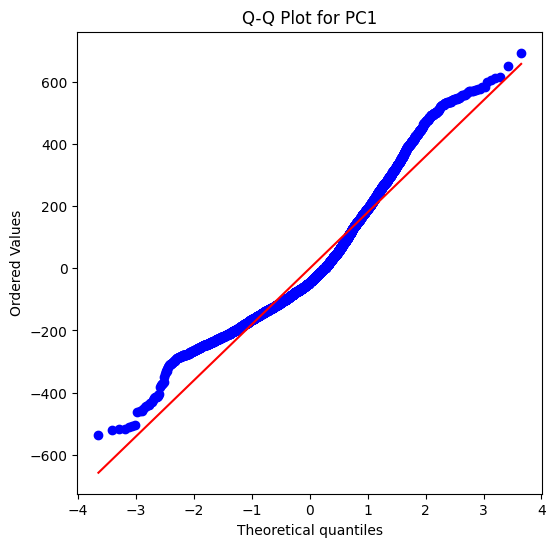

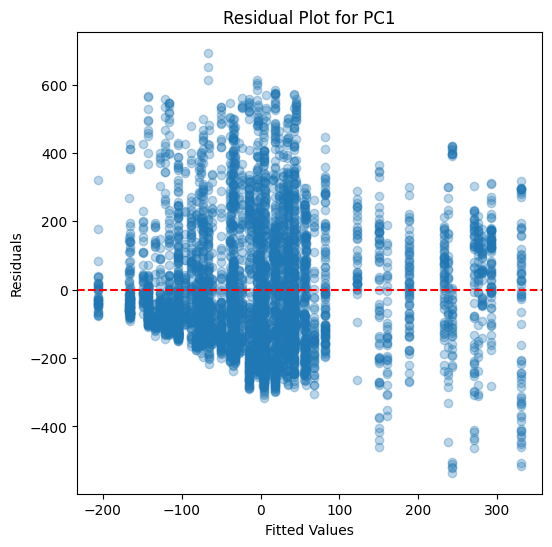

/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/statsmodels/base/model.py:607: Conve

Summary for PC2:
                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     PC2        
No. Observations:       5260        Method:                 REML       
No. Groups:             36          Scale:                  27619.4880 
Min. group size:        70          Log-Likelihood:         -34395.2007
Max. group size:        265         Converged:              No         
Mean group size:        146.1                                          
-----------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
-----------------------------------------------------------------------
Intercept             -981.564  442.165 -2.220 0.026 -1848.192 -114.937
C(day_night)[T.Night]    2.011    4.590  0.438 0.661    -6.985   11.007
log_NDVI               269.605  165.257  1.631 0.103   -54.294  593.503
log_alt                131.401   61.894  2.123 0.034    10.092  

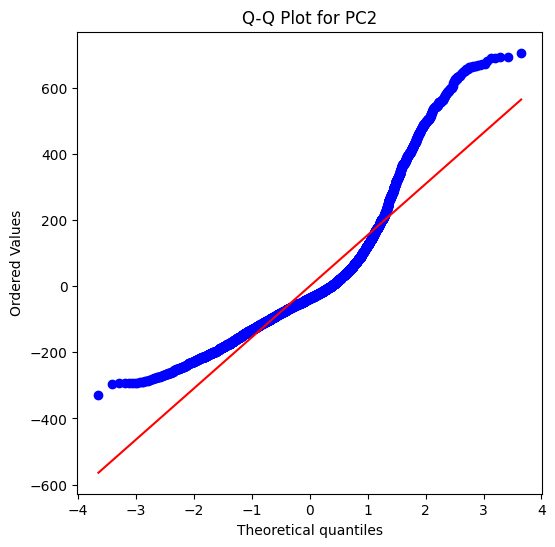

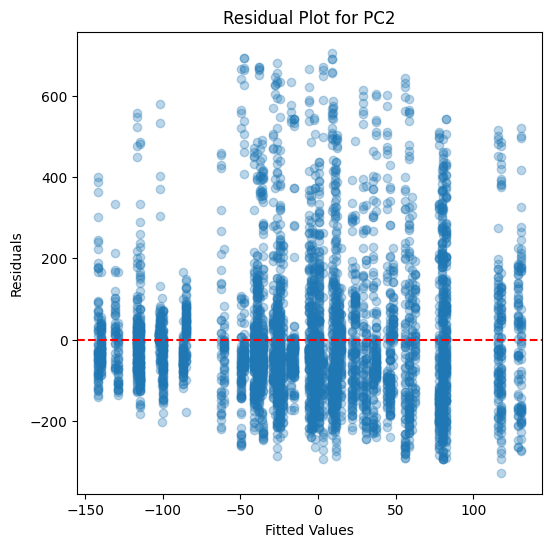

Summary for PC3:
                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      PC3        
No. Observations:       5260         Method:                  REML       
No. Groups:             36           Scale:                   10500.9853 
Min. group size:        70           Log-Likelihood:          -31862.7202
Max. group size:        265          Converged:               Yes        
Mean group size:        146.1                                            
-------------------------------------------------------------------------
                        Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------
Intercept             -1636.393  357.665  -4.575 0.000 -2337.404 -935.383
C(day_night)[T.Night]   -84.006    2.830 -29.682 0.000   -89.553  -78.459
log_NDVI                 44.140  133.776   0.330 0.741  -218.057  306.337
log_alt                 240.388   50.06

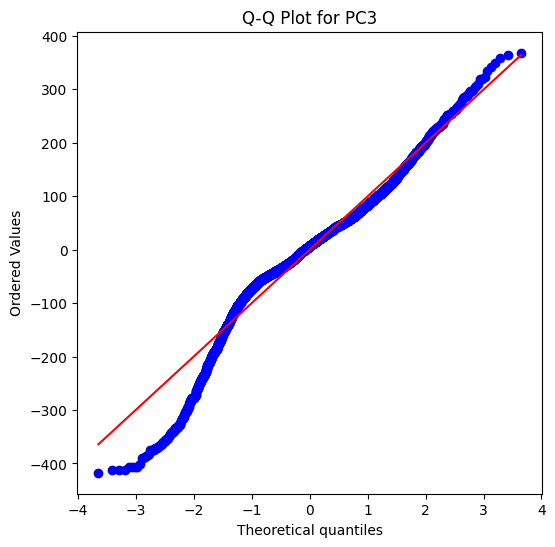

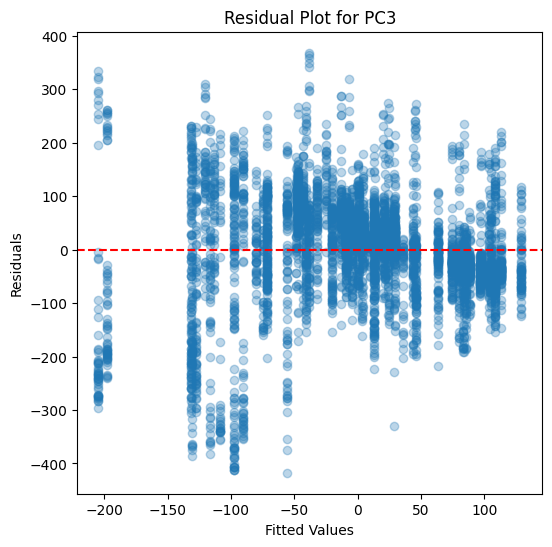

/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


Summary for PC4:
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     PC4        
No. Observations:      5260        Method:                 REML       
No. Groups:            36          Scale:                  5921.3510  
Min. group size:       70          Log-Likelihood:         -30354.1247
Max. group size:       265         Converged:              Yes        
Mean group size:       146.1                                          
----------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------
Intercept             -485.001  245.172  -1.978 0.048 -965.528  -4.473
C(day_night)[T.Night]  -22.285    2.125 -10.486 0.000  -26.450 -18.119
log_NDVI                58.698   91.681   0.640 0.522 -120.993 238.390
log_alt                 69.528   34.317   2.026 0.043    2.268 136.789
Group 

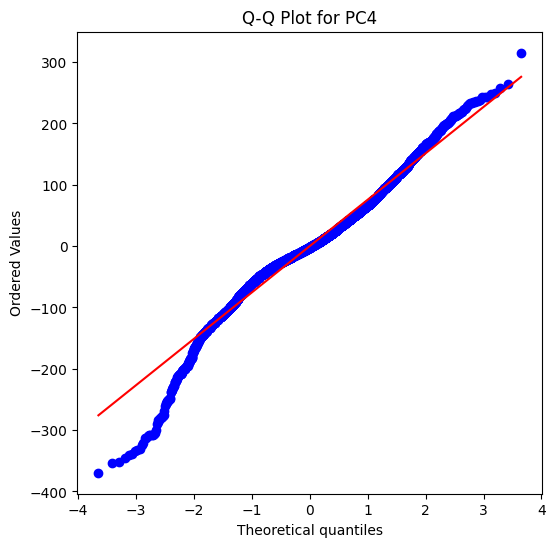

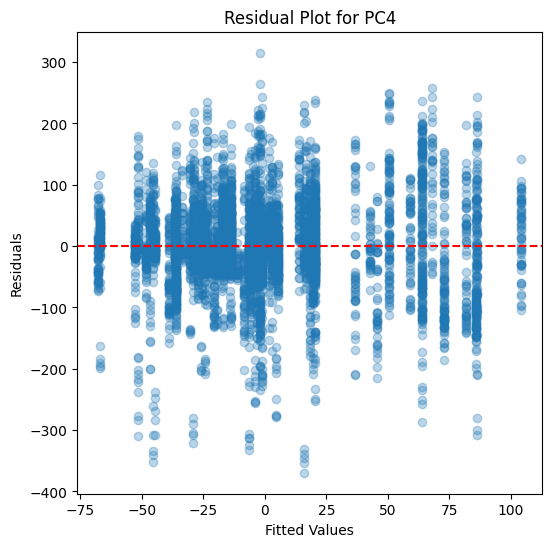

In [45]:
# Mixed Effect Models analysis, response variable [embeddings PCA] = NDVI + altitude + day/night as the predictor variables, and Site ID as the random intercept
for i in range(4):
    formula = f'PC{i+1} ~ log_NDVI + log_alt + C(day_night)'
    model = MixedLM.from_formula(formula, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
    result = model.fit()
    p_values = result.pvalues
    print(f'Summary for PC{i+1}:')
    print(result.summary())
    print('\n' + '='*80 + '\n')
    for param, p_val in p_values.items():
        print(f'{param}: {p_val:.20e}')

    residuals = result.resid
    fitted = result.fittedvalues

    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for PC{i+1}')
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(fitted, residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot for PC{i+1}')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()

In [53]:
import seaborn as sns

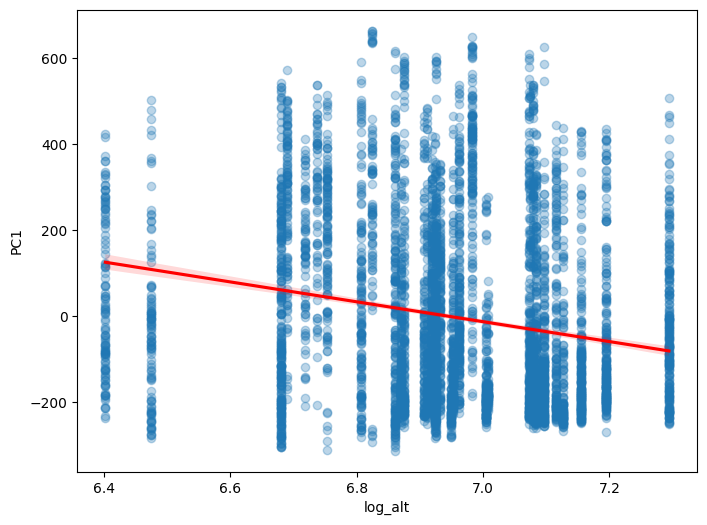

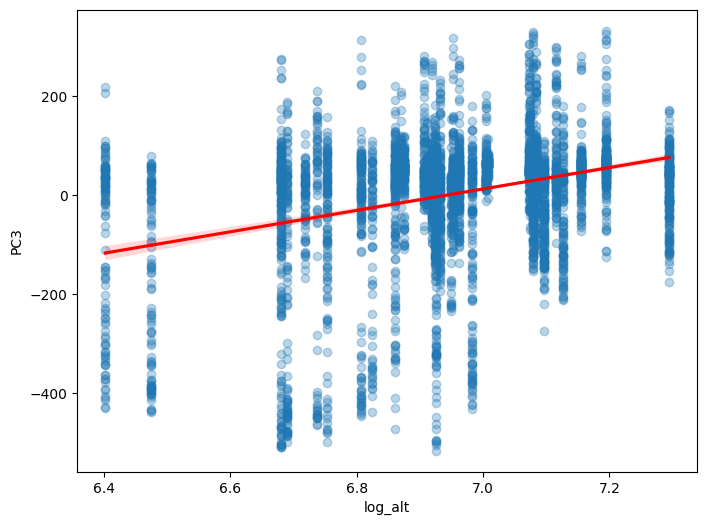

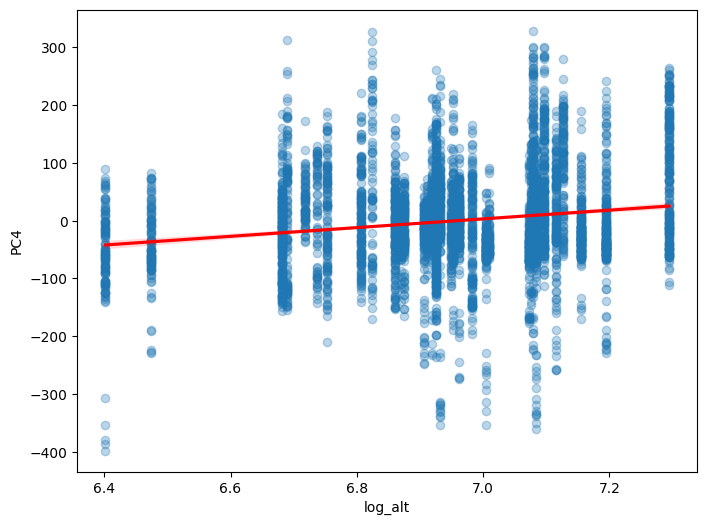

In [54]:
for i in [0, 2, 3]:
    formula_plot = f'PC{i+1} ~ log_NDVI + log_alt + C(day_night) + log_species_richness'
    model_plot = MixedLM.from_formula(formula_plot, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
    result_plot = model_plot.fit()

    data_plot = mixed_effect_model_df.copy()
    data_plot['fitted'] = result_plot.fittedvalues
    data_plot['residuals'] = result_plot.resid

    plt.figure(figsize=(8, 6))
    
    sns.regplot(x='log_alt', y=f'PC{i+1}', data=data_plot, 
                scatter_kws={'alpha':0.3}, 
                line_kws={'color':'red'},
                ci=95)
    
    plt.xlabel('log_alt')
    plt.ylabel(f'PC{i+1}')
    plt.show()

Summary for species richness:
              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_species_richness
No. Observations: 5260    Method:             REML                
No. Groups:       36      Scale:              0.0000              
Min. group size:  70      Log-Likelihood:     65925.2340          
Max. group size:  265     Converged:          Yes                 
Mean group size:  146.1                                           
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                4.733    0.124 38.055 0.000  4.489  4.977
C(day_night)[T.Night]   -0.000    0.000 -0.000 1.000 -0.000  0.000
log_NDVI                -0.602    0.239 -2.524 0.012 -1.070 -0.135
alt                      0.002    0.000 26.263 0.000  0.002  0.003
Group Var                0.009  226.690        

/Users/caihanzhe/.pyenv/versions/3.10.9/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


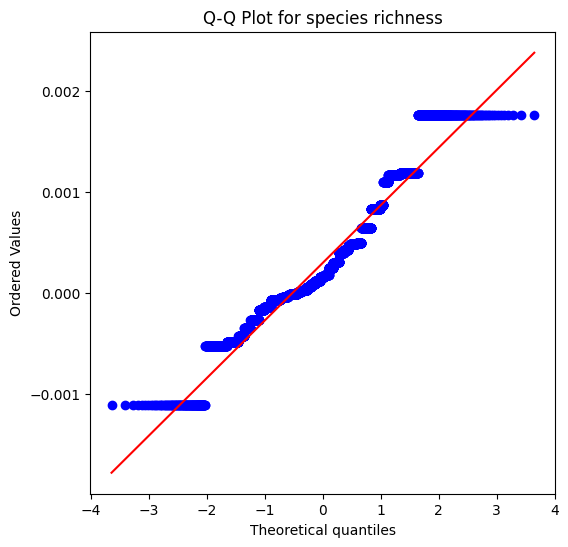

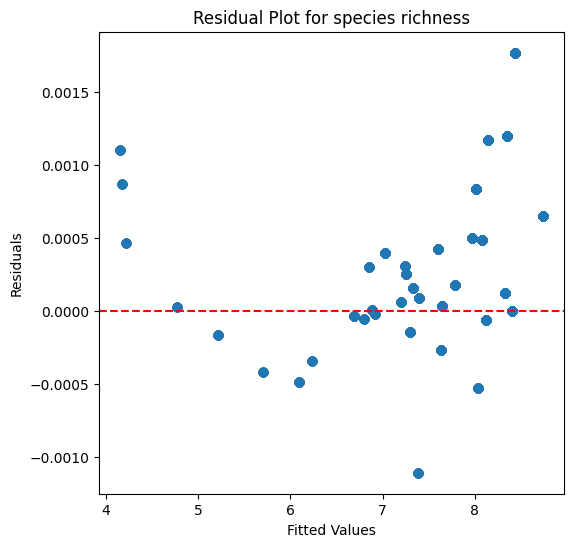

In [49]:
# Mixed Effect Models analysis, response variable [species richness per site] = NDVI + altitude + day/night as the predictor variables, and Site ID as the random intercept
formula_ = f'log_species_richness ~ log_NDVI + alt + C(day_night)'
model_ = MixedLM.from_formula(formula_, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
result_ = model_.fit()
p_values_ = result_.pvalues
print(f'Summary for species richness:')
print(result_.summary())
for param, p_val in p_values_.items():
    print(f'{param}: {p_val:.20e}')

residuals_ = result_.resid
fitted_ = result_.fittedvalues

plt.figure(figsize=(6, 6))
stats.probplot(residuals_, dist="norm", plot=plt)
plt.title(f'Q-Q Plot for species richness')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(fitted_, residuals_, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for species richness')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()